# Section 5 : Multispectral Remote Sensing Data in Python
## Chapter 9 : Replace raster cell values

[![Foo](https://www.colorado.edu/brand/sites/default/files/styles/medium/public/page/boulder-one-line_0.png)](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/)

Le notebook précédent a montré comment supprimer des pixels invalides sur une images en se servant d'un masque. Cette solution n'est pas parfaite et on peut en considérer d'autres. Dans ce notebook, on remplace les pixels invalides cachés par le nuage avec les valeurs de pixels contenus dans une autre image. Cette opération sera réalisée avec le package Xarray. 

***
On commence par importer les packages nécessaires pour le notebook. 
Puis on télécharge les deux images qui seront combinées. Bien que de noms différents, les deux images font référence aux mêmes incendies de Cold Springs dans le Colorado en 2016. 

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
from numpy import ma
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
data_2 = et.data.get_data('cs-test-landsat')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

***
Avec les mêmes techniques que précédemment, on importe les bandes spectrales correspondantes au visible RGB pour les images mentionnées plus haut. Les fichiers `.tif` extraits sont alors combinés pour donner le fichier `landsat_pre_cloud`. En plus de ces opérations, l'utilisation de la fonction `rio.bounds()` permet de déterminer les limites de l'image `landsat_pre_cloud` ce qui sera utile pour la suite du notebook. Puis on importe également l'image qui représente les perturbations à l'observation qui est ensuite convertie en un masque en spécifiant les perturbations à considérer. Enfin, ce masque est appliqué au tableau multidimensionnel `landsat_pre_cloud`. On affiche le tableau produit `landsat_pre_cloud_masked` pour retrouver l'image finale du notebook précédent.

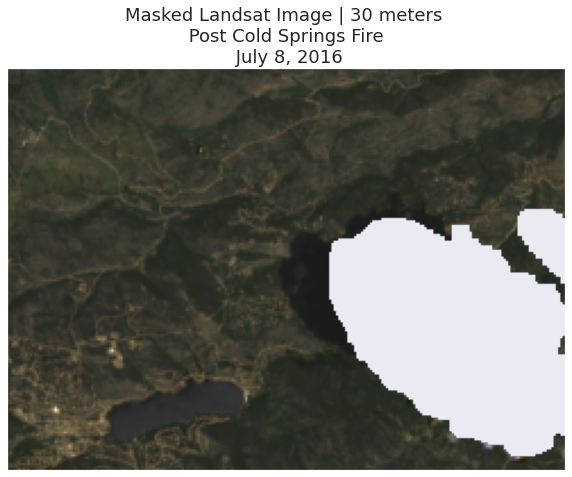

In [2]:
# Custom function to read in list of tifs into an xarray object
def combine_tifs(tif_list):
    out_xr=[]
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"]=i+1
     
    return xr.concat(out_xr, dim="band") 

# Stack the Landsat pre fire data
landsat_paths_pre_path = os.path.join("cold-springs-fire", 
                                      "landsat_collect",
                                      "LC080340322016070701T1-SC20180214145604", 
                                      "crop",
                                      "*band[2-4]*.tif")

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

landsat_pre_cloud = combine_tifs(landsat_paths_pre)


# Calculate bounds object
landsat_pre_cloud_ext_bds = landsat_pre_cloud.rio.bounds()

# Open the pixel_qa layer for your landsat scene
landsat_pre_cl_path = os.path.join("cold-springs-fire", 
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604", 
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

# Generate array of all possible cloud / shadow values
cloud_shadow = [328, 392, 840, 904, 1350]
cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
high_confidence_cloud = [480, 992]

vals_to_mask = cloud_shadow + cloud + high_confidence_cloud

# Call the earthpy mask function using pixel QA layer
landsat_pre_cloud_masked = landsat_pre_cloud.where(~landsat_qa.isin(vals_to_mask))

# Masking out NA values with numpy in order to plot with ep.plot_rgb
landsat_pre_cloud_masked_plot = ma.masked_array(landsat_pre_cloud_masked.values, landsat_pre_cloud_masked.isnull())

ep.plot_rgb(landsat_pre_cloud_masked_plot,
            rgb=[2, 1, 0],
            title="Masked Landsat Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()



***
A présent, il faut importer l'image vierge de nuages avec la même procédure que pour la précédente. On s'intéresse également uniquement aux bandes spectrales du visible que l'on combine pour donner naissance au tableau multidimensionnel `landsat_pre_cloud_free`. Tout l'enjeu est maintenant de remplacer les pixels invalides de l'ancienne image par ceux correspondants dans la nouvelle image. Cependant, absolument rien ne nous garantit a priori que les images ont la même taille et illustrent la même surface au sol. 

On commence par extraire leurs dimensions pour vérifier si les deux tableaux ont les mêmes dimensions. Malheureusement, ce n'est pas le cas et on va donc être obligé de retailler l'image sans nuage pour réaliser l'opération de remplacement des pixels. Si on s'intéresse séparément à `landsat_pre_cloud.shape` et à `landsat_pre_cloud_free.shape`, on s'aperçoit que ce dernier est largement plus grand que le premier sur chacune de ses bandes spectrales avec une taille de (3, 7911, 7791) contre (3, 177, 246) pour le premier. Cela explique la nécessité de recadrer l'image sans nuage avant de procéder au remplacement des pixels. 

In [3]:
# Read in the "cloud free" landsat data that you downloaded as a part of your homework
landsat_paths_pre_cloud_free = glob(
    os.path.join("cs-test-landsat", "*band[2-4]*.tif"))

landsat_paths_pre_cloud_free.sort()
landsat_pre_cloud_free = combine_tifs(landsat_paths_pre_cloud_free)

# Are the shapes the same?
landsat_pre_cloud.shape == landsat_pre_cloud_free.shape

False

***
Dans le même objectif, on vérifie si les images ont leurs coordonnées exprimées dans le même système de coordonnées. Heureusement, c'est le cas sinon il n'aurait pas été possible de continuer cette procédure de remplacement comme les pixels des deux images n'auraient pas représentés la même surface au sol. 

On sait déjà que les images n'ont pas les mêmes tailles. On peut se poser la question de savoir quelles sont leurs limites. Comme on pouvait s'y attendre, les limites (gauche, inférieure, droite, supérieure) de chaque image dans le système de coordonnées CRS sont différentes comme la taille des images est différente pour une même résolution. Avant d'effectuer le remplacement de pixel, il va donc falloir recadrer le tableau `landsat_pre_cloud_free`.

La cellule suivante transforme les limites des images en boîte via la fonction `box` du package `shapely.geometry`. Fort heureusement, on s'aperçoit que les deux images s'intersectent. C'est-à-dire que les pixels à remplacer dans l'image d'origine sont bien présents dans l'image sans nuage. 

Enfin, on affiche les deux boîtes dans un graphique qui montre bien l'inclusion et l'intersection des deux images. L'image sans nuage (contour bleu) est bien plus grande en surface que l'image d'origine (contour mauve) ce qui en fait un tableau difficile à manipuler. Le mieux est de réaliser l'opération de recadrage sur la nouvelle image pour diminuer sa taille mémoire. 

In [4]:
# Is the CRS the same in each raster?
landsat_pre_cloud.rio.crs == landsat_pre_cloud_free.rio.crs

True

In [5]:
# Calculate bounds object
landsat_no_clouds_bds = landsat_pre_cloud_free.rio.bounds()

# Are the bounds the same?
landsat_no_clouds_bds == landsat_pre_cloud_ext_bds

False

In [6]:
# Make polygons from the bounds
cloud_free_scene_bds = box(*landsat_no_clouds_bds)
cloudy_scene_bds = box(*landsat_pre_cloud_ext_bds)

# Do the data overlap spatially?
cloud_free_scene_bds.intersects(cloudy_scene_bds)

True

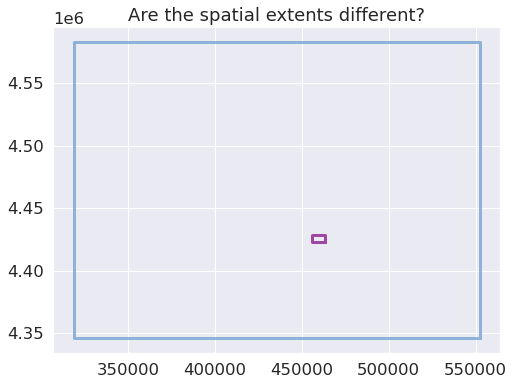

In [7]:
# Plot the boundaries
x, y = cloud_free_scene_bds.exterior.xy
x1, y1 = cloudy_scene_bds.exterior.xy

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.plot(x1, y1, color='purple', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.set_title('Are the spatial extents different?')

plt.show()


***
Les limites de l'image initiale sont converties dans un format adapté au recadrage. On commence par recadrer `landsat_pre_cloud_free` qui contient l'image sans nuage pour adapter sa taille à l'image initiale. On peut voir sur la sortie de la dernière ligne que l'image mise-à-jour `landsat_pre_cloud_free` a les mêmes dimensions que l'image initiale masquée `landsat_pre_cloud_masked` ce qui rend possible le remplacement des pixels. 

In [11]:
landsat_clouds_clip = es.extent_to_json(list(landsat_pre_cloud_ext_bds))

# Clip the data to the extent of the other landsat scene
landsat_pre_cloud_free = landsat_pre_cloud_free.rio.clip([landsat_clouds_clip])

# View the shape of each scene. are they the same?
landsat_pre_cloud_free.shape, landsat_pre_cloud_masked.shape

((3, 177, 246), (3, 177, 246))

***
Pour réaliser le remplacement, on commence par récupérer le masque des pixels invalides de l'image initiale masquée avec la fonction `isnull()`. Le remplacement est plus complexe que seulement ajouter les pixels de l'image sans nuage sur ceux invalides de l'image initiale. En effet, la fonction `xr.where()` crée un nouveau tableau où est copié le pixel de l'image de départ si le booléen correspondant du masque est `False` ou le pixel de l'image sans nuage si le booléen correspondant du masque est `True`. Enfin, on reforme un tableau masqué pour le tracer facilement avec `ep.plot_rgb`. A noter que l'on peut vérifier que le masque `landsat_pre_cloud_masked_val_replace.isnull()` est un tableau aux mêmes dimensions que `landsat_pre_cloud_masked_val_replace` rempli de valeur `False` étant donné qu'aucun pixel n'est vide ou invalide comme les pixels invalides de l'image initiale ont tous été remplacés par les pixels de l'image sans nuage. 

Dans l'affichage de l'image initiale mise-à-jour, on peut voir que les pixels du sol cachés par le nuage ont bien été remplacés par des pixels dont la géographie correspond assez bien à celle de Cold Springs. Cependant, comme vu dans le notebook précédent, l'ombre portée du nuage a mal été définie dans le fichier de perturbations. Cela implique donc que les pixels ombragés non considérés par le fichier de pertubations n'ont eux pas été remplacés par les pixels de l'image sans nuage. En effet, on peut voir sur l'image affichée ci-dessous une séparation nette entre la zone de pixels remplacés et l'ombre portée du nuage non considérée par les perturbations. Un travail supplémentaire devrait être mené sur le fichier de perturbations pour mieux redéfinir la zone de l'ombre portée du nuage. On peut également voir dans la partie inférieure de l'affichage que la délimitation du nuage a été faite de manière assez inexacte. Le point le plus brillant qui représente probablement un batîment a été découpé par la procédure de remplacement. Cela est possiblement dû au manque de résolution du cliché. Une meilleure résolution aurait peut-être permis d'effectuer un détourage du nuage plus précis et donc un remplacement des pixels plus précis. 

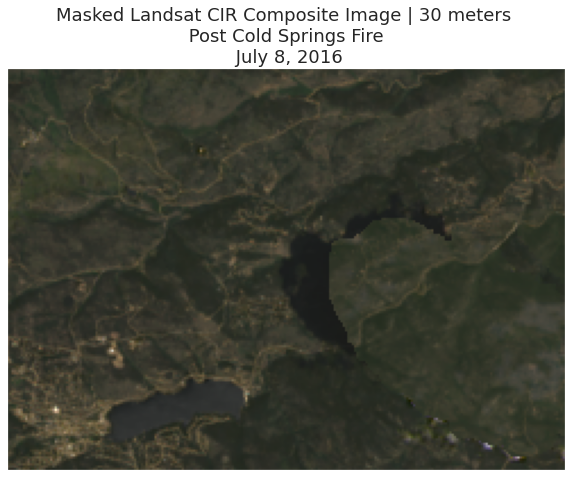

In [23]:
# Get the mask layer from the pre_cloud data
mask = landsat_pre_cloud_masked.isnull()

# Assign every cell in the new array that is masked
# to the value in the same cell location as the cloud free data
landsat_pre_cloud_masked_val_replace = xr.where(mask, landsat_pre_cloud_free, landsat_pre_cloud_masked)

# Masking out NA values with numpy in order to plot with ep.plot_rgb
landsat_pre_cloud_masked_val_replace_plot = ma.masked_array(landsat_pre_cloud_masked_val_replace.values, landsat_pre_cloud_masked_val_replace.isnull())

ep.plot_rgb(landsat_pre_cloud_masked_val_replace_plot,
            rgb=[2, 1, 0],
            title="Masked Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()


### Pour conclure ce notebook, on a vu comment remplacer les pixels invalides d'un précédent tableau masqué en utilisant un autre cliché. Les transformations principales sont le recadrage et la création d'une image mise-à-jour en choisissant les pixels selon un masque prédéfini. 